### one-hotでは未知の初期値に対応できないので、スカラで表して解決する？
* 元々スカラで状態を表すと、xの値が大きいほど評価値が高く勾配に大きく影響を与えるという問題が起こる。  
xの値が大きいほど、[-1, /2]が大きく評価されるという関係はある。これをどう表現する？

* 状態ベクトルを$s = [x_{now}, x_{init}]^T $としても線形モデルで存在した、$x_{now}$に関わらず$x_{init}$によって評価値が高くなる

### 学習率の調整はいらないのか？

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [11]:
def x2vec(x):
    vec = np.zeros(11)
    vec[x] = 1
    return vec

def vec2x(vec):
    return np.argmax(vec)

In [70]:
def next_state(s, a):
    s0 = s[-2]
    s = vec2x(s[:11])
    if a == 0:
        s_next = s * 2
    elif a == 1:
        s_next = s + 1
    elif a == 2:
        s_next = s
    elif a == 3:
        s_next = s - 1
    elif a == 4:
        s_next = s // 2
    s_next = max(0, min(10, s_next))
    s_next_vec = x2vec(s_next)
    return np.r_[s_next_vec, s0, 1]

In [13]:
# def reward_func(s, n_state, done, T):  # 加藤の実験コードを反映
#     total = 0
#     s = vec2x(s[:12])
#     n_state = n_state[0]
#     if n_state > 10 or n_state < 0:
#         total += -abs(n_state - T)/10
#     diff = abs(T - n_state) - abs(T - s)
#     if diff > 0:
#         total += -3 * diff
#     if done and n_state != T:
#         return -2
#     elif done:
#         loss_reward = 2 * (10 - abs(n_state - T))/10
#         return loss_reward
#     return -0.5 + total

In [111]:
def reward_func(s, n_state, done, T):  # 加藤の実験コードを反映
    s = vec2x(s[:11])
    n_state = vec2x(n_state[:11])
    if done:
        if n_state != T:
            return -10
        else:
            return 100
    return -1

In [15]:
def step(s, a, T):
    ns = next_state(s, a)
    done = (a == 2)
    r = reward_func(s, ns, done, T)
    return ns, r, done 

In [87]:
def update(Q, batch, lr, gamma=0.9):
    grad = np.zeros((13, 5))
    for e in batch:
        est = e.s @ Q[:, e.a]
        v = e.r
        if not e.d:
            v += gamma * np.max(e.ns[np.newaxis, :] @ Q)
        grad[:, e.a] += (est - v) * e.s
    grad = np.nan_to_num(grad) / len(batch)
    Q -= lr * grad

In [66]:
from collections import defaultdict, namedtuple, deque
import random

def f(x):
    return 10 - x

Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))
starts=list(range(11))

def trial(seed=100, try_num=100000, lr=0.01, eps=0.1):
    # training
    np.random.seed(seed)
    random.seed(seed)
    Q = np.zeros((13, 5))
    R = []
    # each element is [s, a, ns, r, d]
    experiences = deque(maxlen=1024)

    for itr in tqdm(range(try_num)):
        Ri = 0
        s0 = np.random.choice(starts)
        T = f(s0)
        s0_vec = x2vec(s0)
        s = np.r_[s0_vec, s0/10, 1]
        for _ in range(1000):
            # 行動を選択
            a = np.argmax(Q.T @ s) if np.random.rand() >= eps else np.random.randint(5)
            ns, r, d = step(s, a, T)
            e = Experience(s, a, ns, r, d)
            experiences.append(e)
            s = ns
            Ri = Ri + r
            if d:
                break
        if len(experiences) == 1024:
            batch = random.sample(experiences, 32)
            update(Q, batch, lr=lr, gamma=0.9)

        R.append(Ri)
    return Q, R

In [114]:
from scipy.special import softmax
from matplotlib import pyplot as plt
from matplotlib import cm

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

act = ['*2', '+1', 'end', '-1', '/2']

def view(Q, R, n=1000):
    plt.subplot(121)
    plt.plot(moving_average(R, n=n))
    plt.xlabel('# of Trials')
    plt.ylabel('Avg. Reward')
    plt.show()

    for init in range(11):
        U = np.zeros((11, 5))
        for i in range(11):
            s = np.r_[x2vec(i), init/10, 1]
            U[i, :] = softmax(s.T @ Q)
        plt.imshow(U)
        plt.show()

In [68]:
def test(Q):
    solved = []
    for s0 in range(11):
        T = f(s0)
        s0_vec = x2vec(s0)
        s_vec = np.r_[s0_vec, s0/10, 1]
        for _ in range(100):
            a = np.argmax(s_vec.T @ Q)
            if a == 2:
                break
            s_vec = next_state(s_vec, a)
        if vec2x(s_vec[:11]) == T:
            solved.append((s0, T, 'solved!'))
        else:
            solved.append((s0, T, '-'))
    for item in solved:
        print('init = %d, T = %d, %s' % item)
        print()

In [115]:
Q, R = trial(seed=0, eps=0.3, try_num=1000, lr=0.01)

['*2', '+1', 'end', '-1', '/2']
[[-3.77346903e-01 -3.33195852e-01 -1.73173363e+00 -4.17133277e-01
  -5.53877803e-01]
 [-6.14238800e-02 -1.57364767e-01 -1.48634626e+00 -2.08927687e-01
  -2.13713874e-01]
 [-3.65906723e-02 -1.07714280e-01 -1.28808250e+00 -1.25248293e-01
  -1.19805981e-01]
 [-1.77522260e-02 -9.09284126e-02  2.51125423e-01 -7.19601900e-02
  -9.55221789e-02]
 [-2.54996518e-02  7.04160934e-01 -1.97009853e+00 -3.60974970e-02
  -5.84193965e-02]
 [-4.42372212e-02 -3.17278506e-02  1.36144849e+01 -2.09734469e-02
  -1.74470877e-02]
 [-2.17305298e-02 -2.68997210e-02 -1.01085306e+00  3.02388951e-01
  -1.63659396e-02]
 [-1.91402350e-02 -2.83024094e-02 -1.16884927e+00 -2.85985095e-02
  -1.80010700e-02]
 [-1.63366487e-02 -3.46211071e-02 -1.13024366e+00 -4.12246385e-02
  -2.24300726e-02]
 [-4.17587111e-02 -3.37274041e-02 -1.64106746e+00 -3.14549671e-02
  -3.24080125e-02]
 [-3.15778481e-01 -1.21692927e-01 -1.67377639e+00 -8.18413066e-02
   5.15984016e-01]
 [-3.52995662e-01 -8.37937863e-02

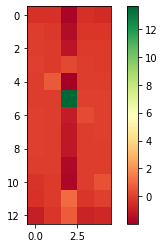

In [119]:
print(act)
print(Q)
im = plt.imshow(Q, cmap=cm.RdYlGn)
plt.colorbar(im)

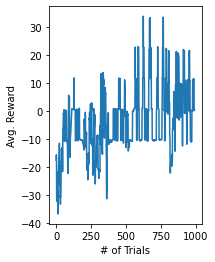

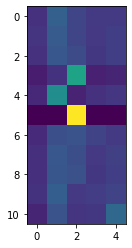

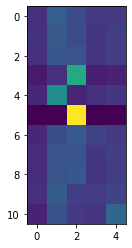

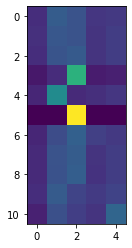

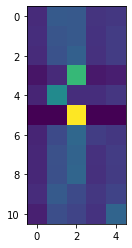

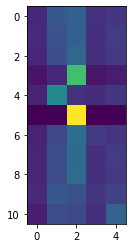

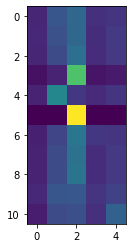

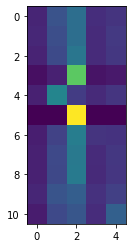

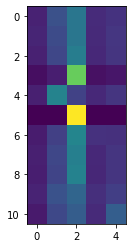

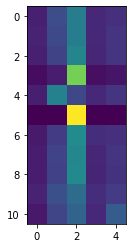

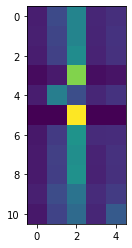

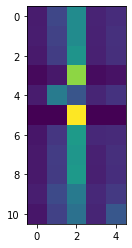

****************************************************************************************************
init = 0, T = 10, -

init = 1, T = 9, -

init = 2, T = 8, -

init = 3, T = 7, -

init = 4, T = 6, -

init = 5, T = 5, solved!

init = 6, T = 4, -

init = 7, T = 3, -

init = 8, T = 2, -

init = 9, T = 1, -

init = 10, T = 0, -



In [117]:
view(Q, R, n=10)
print('*' * 100)
test(Q)

In [109]:
# 0, 10の奇跡を追ってみる
done = False
max_iter = 10
init = 10
print('T =', f(init))
print('*' * 10)
s0_v = x2vec(init)
print(s0_v)
s_v = np.r_[s0_v, init/10]
print(np.arange(12)[s_v.astype(np.bool)], 'h')
for i in range(max_iter):
    a = np.argmax(s_v.T @ Q)
    print('a', act[a])
    if a == 2:
        break
    print(vec2x(s_v[:11]), act[a])
    s_v = next_state(s_v, a)
print(vec2x(s_v[:11]))

T = 0
**********
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[10 11] h


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 13 is different from 12)

In [24]:
f(10)

0